In [1]:
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 19s 0us/step


### Création des chemins pour les ensembles de validation et de training

In [7]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [9]:
train_cats_dir = os.path.join(train_dir, 'cats')  
train_dogs_dir = os.path.join(train_dir, 'dogs')  
validation_cats_dir = os.path.join(validation_dir, 'cats')  
validation_dogs_dir = os.path.join(validation_dir, 'dogs') 

### Compréhension des données

In [10]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [12]:
print("Nombre total d'images de chats dans le training set:", num_cats_tr)
print("Nombre total d'images de chiens dans le training set:", num_dogs_tr)

print('Nombre total d\'images de chats dans le validation set:', num_cats_val)
print('Nombre total d\'images de chiens dans le validation set:', num_dogs_val)
print("--")
print("Nombre total d'images de training:", total_train)
print("Nombre total d'images de validation:", total_val)

Nombre total d'images de chats dans le training set: 1000
Nombre total d'images de chiens dans le training set: 1000
Nombre total d'images de chats dans le validation set: 500
Nombre total d'images de chiens dans le validation set: 500
--
Nombre total d'images de training: 2000
Nombre total d'images de validation: 1000


### Définition des paramètres du modèle

In [13]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Dans le training set on a des images de 150 x 150 pixels

## Data Augumentation

In [14]:
# représenter les images sous la forme d'une grille de 1 ligne et 5 colonnes où les images sont placées dans chaque colonne
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Retourner l'image horizontalement

In [15]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


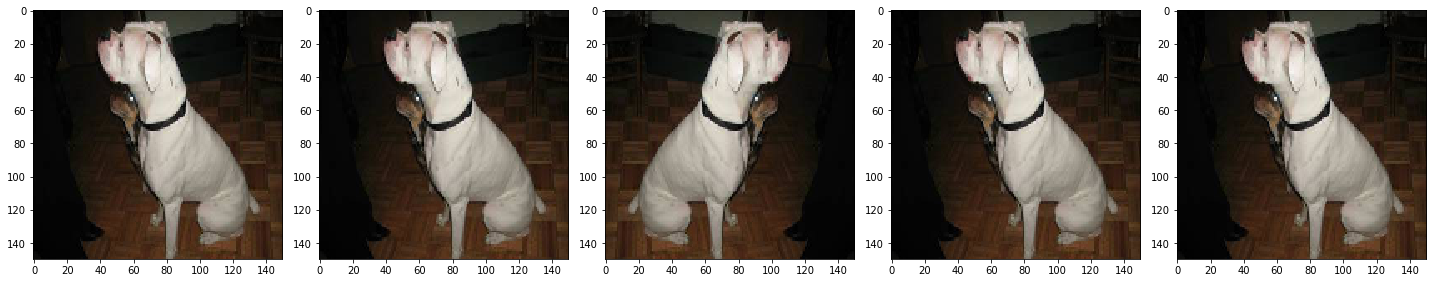

In [19]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Rotation de l'image

In [20]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


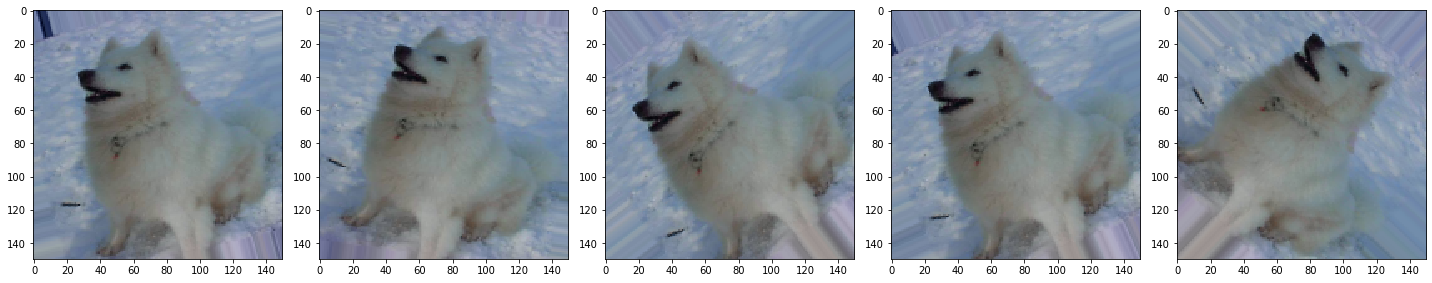

In [21]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Zoomer les images

In [22]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


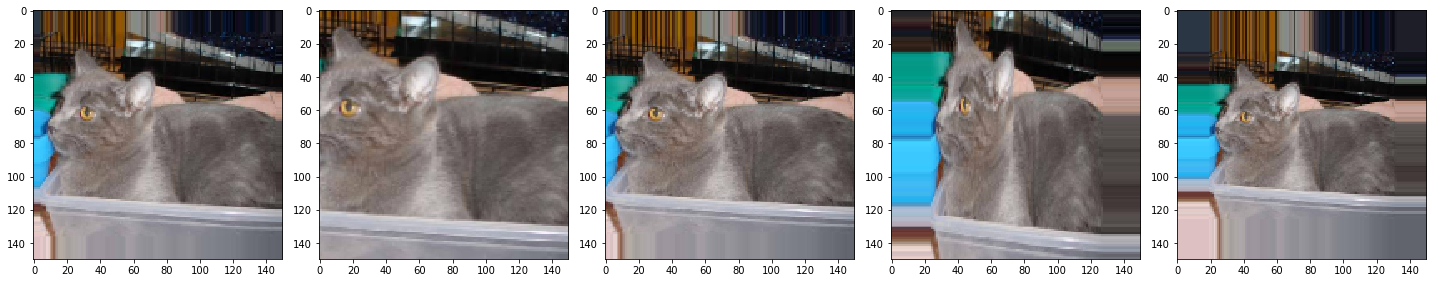

In [23]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Mettre le tout ensemble sur les données de training

In [25]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


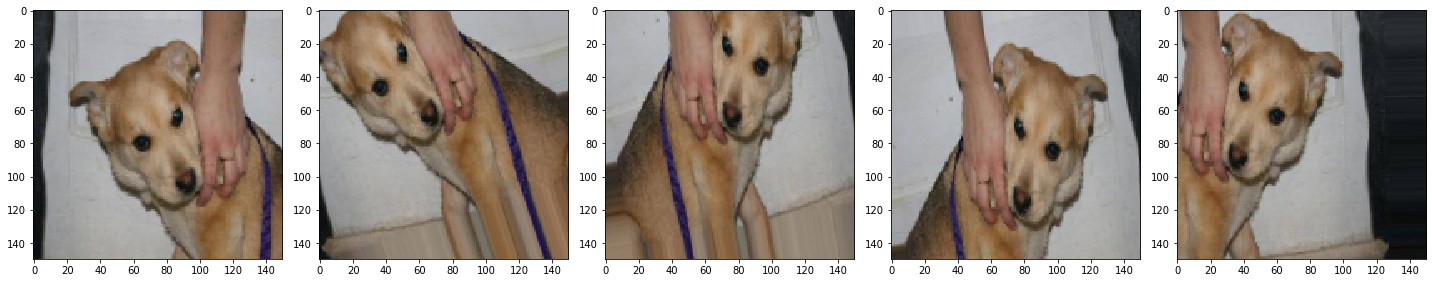

In [26]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Un petit rescaling du validation set

In [27]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Création du modèle

### Définition du modèle:  
Le modèle se compose de quatre blocs de convolution avec une couche de max-pool dans chacun d'eux.
Avant les dernières couches denses, on applique un dropout à 50% 
On a ensuite une couche dense de 512 neurones, avec une fonction d'activation ReLu. 
En sortie on aura des probabilités d'appartenance à deux classes (chiens et chats), on utilisera softmax

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Compilation du modèle

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Résumé du modèle

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Training du modèle 

In [31]:
# du moment où nos batchs proviennent de datagenerator on utilisera fit_generator au lieu de fit
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
20/20 [==============================] - 50s 3s/step - loss: 0.7416 - accuracy: 0.5090 - val_loss: 0.6920 - val_accuracy: 0.5410
Epoch 2/100
20/20 [==============================] - 51s 3s/step - loss: 0.6926 - accuracy: 0.5270 - val_loss: 0.6888 - val_accuracy: 0.5240
Epoch 3/100
20/20 [==============================] - 49s 2s/step - loss: 0.6954 - accuracy: 0.5065 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 4/100
20/20 [==============================] - 50s 2s/step - loss: 0.6922 - accuracy: 0.5230 - val_loss: 0.6887 - val_accuracy: 0.5750
Epoch 5/100
20/20 [==============================] - 49s 2s/step - loss: 0.6825 - accuracy: 0.5720 - val_loss: 0.6652 - val_accuracy: 0.5610
Epoch 6/100
20/20 [==============================] - 48s 2s/step - loss: 0.6752 - accuracy: 0.5830 - val_loss: 0.6779 - val_accuracy: 0.5120
Epoch 7/100
20/20 [==============================] - 49s 2s/step - loss: 0.677

Epoch 57/100
20/20 [==============================] - 53s 3s/step - loss: 0.4287 - accuracy: 0.8065 - val_loss: 0.4117 - val_accuracy: 0.8060
Epoch 58/100
20/20 [==============================] - 53s 3s/step - loss: 0.4158 - accuracy: 0.8025 - val_loss: 0.4061 - val_accuracy: 0.8140
Epoch 59/100
20/20 [==============================] - 49s 2s/step - loss: 0.4235 - accuracy: 0.8085 - val_loss: 0.4167 - val_accuracy: 0.7990
Epoch 60/100
20/20 [==============================] - 48s 2s/step - loss: 0.4376 - accuracy: 0.7955 - val_loss: 0.4076 - val_accuracy: 0.8140
Epoch 61/100
20/20 [==============================] - 49s 2s/step - loss: 0.3980 - accuracy: 0.8120 - val_loss: 0.4570 - val_accuracy: 0.7900
Epoch 62/100
20/20 [==============================] - 48s 2s/step - loss: 0.3947 - accuracy: 0.8215 - val_loss: 0.4355 - val_accuracy: 0.8070
Epoch 63/100
20/20 [==============================] - 50s 3s/step - loss: 0.4173 - accuracy: 0.8130 - val_loss: 0.4899 - val_accuracy: 0.7670
Epoch 

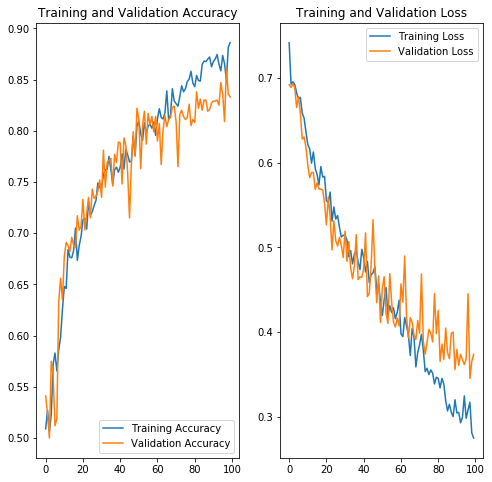

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()